In [1]:
import datetime
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import pylab
import scipy as sp
import scipy.stats


from datetime import datetime, date, time, timedelta
from numpy import array, polyfit, poly1d
from pandas import DataFrame, to_datetime
from pandas.plotting import register_matplotlib_converters
from scipy.stats import norm,rayleigh
from tkinter import *
from tkinter import filedialog

register_matplotlib_converters()

%matplotlib inline

In [2]:
def get_file():

# Select input file
    root = Tk()
    root.filename =  filedialog.askopenfilename(initialdir = 'C:\QGHL\Wave_data', title = 'Select PRIM master file',\
                        filetypes = (('all files','*.*'),('Prim files','*.prim'),('Seco files','*.seco')))
    root.destroy()
    
    print(root.filename)

    return(root.filename)

In [3]:
def addYears(d, years):
#add year(s) with a given date

    try:
#Return same day of the current year        
        return d.replace(year = d.year + years)
    except ValueError:
#If not same day, it will return other, i.e.  February 29 to March 1 etc.        
        return d + (date(d.year + years, 1, 1) - date(d.year, 1, 1))

In [4]:
def Date_range(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

In [13]:
############################################
#    MAIN PROGRAM
############################################

# Create a DT based on the structure type of the PRIM Master File
# Details copied from PV~Wave file Master_structure_types_corrected.pro
pp1 = np.dtype([
    ('P1', 'B'),('P2', 'B'),('P3', 'B'),('P4', 'B'),('P5', 'B'),('P6', 'B'),('P7', 'B'),('P8', 'B')])

rectype_prim = np.dtype([
#    ('Year','i2'),('Month','i2'),('Day', 'i2'),('Hour', 'i2'),('Min', 'i2'), ('Sec','i2'), 
    ('Date_val','i2',(6)), 
    ('Buoy','i2'),
#    ('verstr',pp1),
    ('verstr','B',(8,)),
    ('Hsig','f4'),('Hm','f4'), ('Hmax', 'f4'),('Tz', 'f4'),('Thsig','f4'),('Tc', 'f4'), 
    ('Thmax', 'f4'),('Eps', 'f4'),('T02', 'f4'),
    ('Tp', 'f4'),('Hrms', 'f4'),('Epss', 'f4'),
    ('Noise', 'i2'),('Nspike', 'i2'),('Nroc', 'i2'),
    ('Errors', 'f4'),('Spikemax', 'f4'),('Rocmax', 'f4'),
    ('Samax', 'i2'),('Sigma', 'f4'),('Burlen', 'i2'),('Deltat', 'f4'),('Nwaves', 'i2'),
    ('Tzmax', 'f4'),('E04', 'f4'),('E60', 'f4'),
    ('Ierr', 'i2'),('Start', 'i2'),('Burint', 'i2'),
    ('H10', 'f4'),('Th10', 'f4'),
    ('Elapse', 'i2'),
    ('Hm0', 'f4'),('Dtz', 'f4'),('Pdens', 'f4'),('Rtemp', 'f4'),('Wtemp', 'f4'),
    ('Status', 'i2'),
    ('Vacc', 'f4'),('Xacc', 'f4'),('Yacc', 'f4'),('Orient', 'f4'),('Inclin', 'f4'),
    ('Pktdir', 'f4'),('Avedir', 'f4'),('Pkdir', 'f4'),
    ('Pad', 'B',(72,))])

# Create a DT based on the structure type of the SECO Master File
# Details copied from PV~Wave file Master_structure_types_corrected.pro
rectype_seco = np.dtype([
#    ('Year','i2'),('Month','i2'),('Day', 'i2'),('Hour', 'i2'),('Min', 'i2'), ('Sec','i2'), 
    ('Date_val','i2',(6)), 
    ('Buoy','i2'),
    ('verstr','B',(8,)),
    ('m0','f4'),('m1','f4'), ('m2', 'f4'),('m4', 'f4'),('Tp','f4'),('board', 'f4', (128,)), 
    ('Elapse', 'i2'),('Hm0', 'f4'),('Pktdir', 'f4'),('Avedir', 'f4'),('Pkdir', 'f4'),('Pdens', 'f4'),
    ('Jdir', 'i2', (64,)),('Jpower', 'i2', (64,)),('Jspread', 'i2', (64,)),
    ('Pad', 'B', (64,))])

Start_File = get_file()
date_str = Start_File.split('/')[-1].split('.')[0]
Start_time = datetime.strptime(date_str[3:], "%d%m%Y")

# Get name of input PRIM file
site = Start_File.split('/')[-1].split('}')[0].upper()

##End_File = get_file()
##date_str = End_File.split('/')[-1].split('.')[0]
##End_time = datetime.strptime(date_str[3:], "%d%m%Y")
End_time = addYears(Start_time, 1)

Path = os.path.dirname(Start_File)
File_name = os.path.basename(Start_File)

Front_part = Start_File.split('/')[0]
Extension = Start_File.split('.')[-1]

Days = (End_time-Start_time).days

recs = pd.DataFrame([])

aa = []

for dt in Date_range(Start_time, End_time):
    Input_File = Path+'/'+date_str[0:3]+dt.strftime("%d%m%Y")+'.'+Extension

    error_to_catch = getattr(__builtins__,'FileNotFoundError', IOError)

    try:
# Read data from the HVA file
        print('Reading data from RTWS Prim file:',Input_File)
        # Open file
        f = open(Input_File)

# Read data from the Binary file into a DF based on the structure in the DT
        data = np.fromfile(f, rectype_prim)
        aa.append(DataFrame.from_records(np.array(data).tolist()))
  
    except error_to_catch:
        print('WARNING... ',Input_File,' NOT Found!')

recs = pd.concat(aa)
# Assign column names to DF
recs.columns = ['Date_val','Buoy','Verstr','Hsig','Hm','Hmax','Tz','Thsig','Tc','Thmax','Eps','T02',
                'Tp','Hrms','Epss','Noise','Nspike','Nroc','Errors','Spikemax','Rocmax',
                'Samax','Sigma','Burlen','Deltat','Nwaves','Tzmax','E04','E60','Ierr','Start',
                'Burint','H10','Th10','Elapse','Hm0','Dtz','Pdens','Rtemp','Wtemp','Status',
                'Vacc','Xacc','Yacc','Orient','Inclin','Pktdir','Avedir','Pkdir','Pad']

# Convert date/time column data into Dates and times
Record_time = pd.DataFrame(recs.Date_val.values.tolist(), \
        columns=['year','month','day','hour','minute','second'])

Record_time['year'] = Record_time['year'].mask(Record_time['year'] < 1900, Record_time['year'] + 1900)

# Insert Date column at start of DF
recs.index = pd.to_datetime(Record_time[['year','month','day','hour','minute','second']],format='%Y:%m:%d:%H:%M:%S')

print('Program Finished')


C:/QGHL/Wave_data/tweedheads_4225/HVA/tweedheads_4225}2018-12-01T00h00Z.hva


ValueError: time data 'edheads_4225}2018-12-01T00h00Z' does not match format '%d%m%Y'

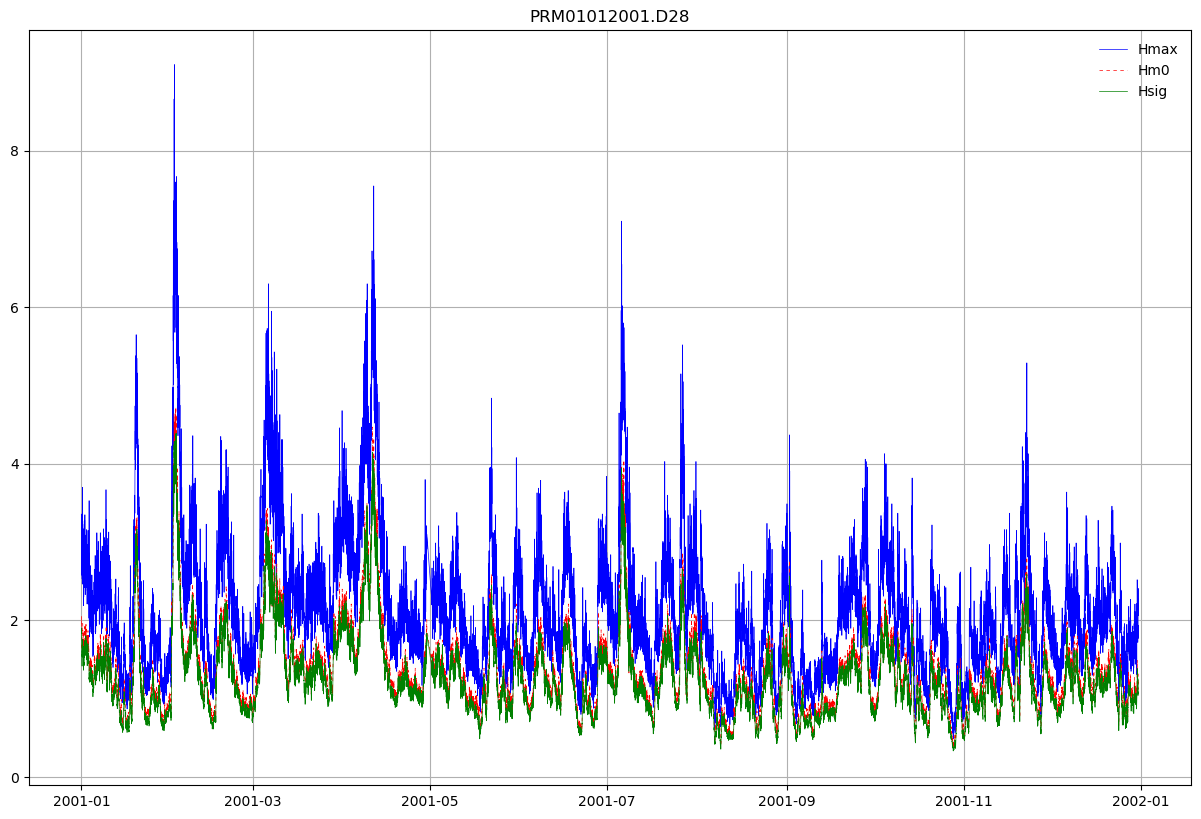

In [34]:
plt.figure(figsize=(15,10),dpi=100)
plt.title(site)

# only plot records where Hsig > 0
recs = recs.loc[recs.Hsig>0]

plt.grid(True)
plt.plot(recs.index,recs.Hmax,lw=0.5,c="b")
plt.plot(recs.index,recs.Hm0,lw=0.5,c="r",dashes=[5, 5, 5, 5])
plt.plot(recs.index,recs.Hsig,lw=0.5,c="g")
plt.legend(["Hmax", "Hm0", "Hsig"],frameon=False)
#plt.legend()
plt.show()

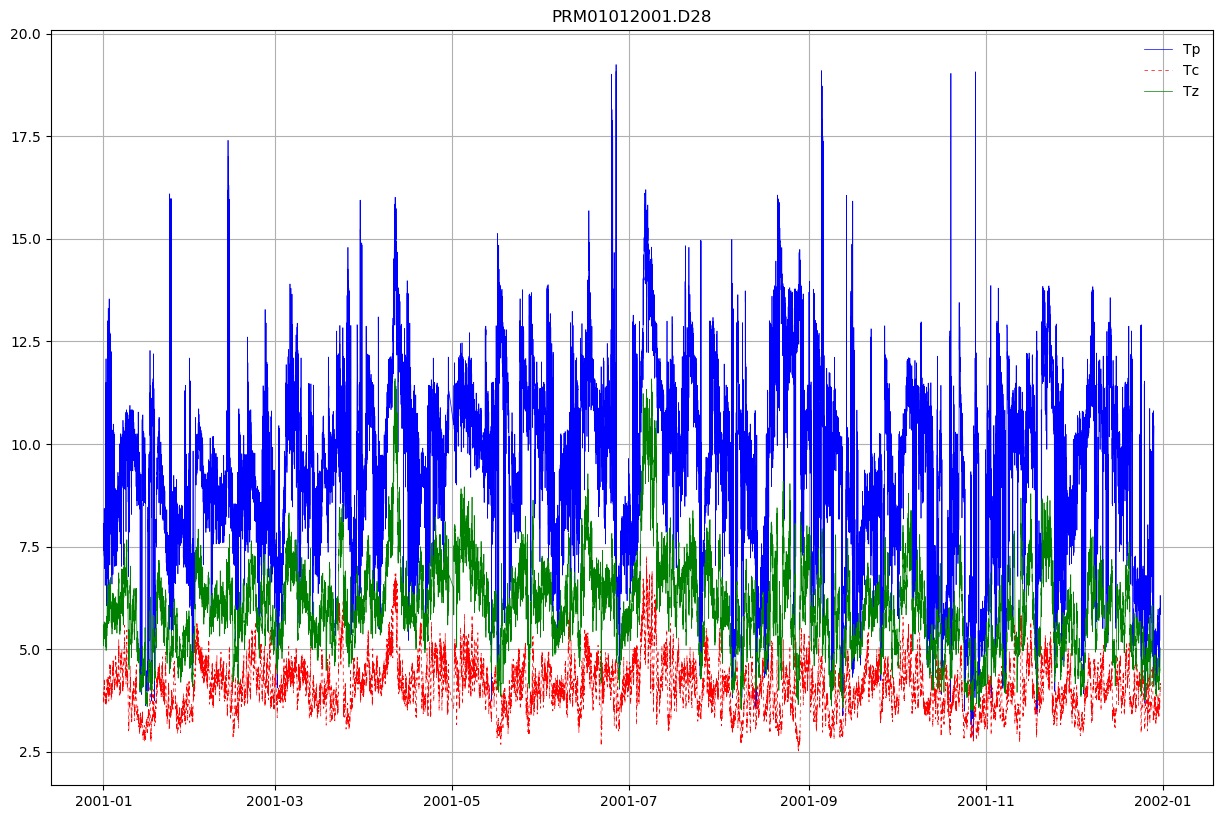

In [33]:
plt.figure(figsize=(15,10),dpi=100)
plt.title(site)

# only plot records where Hsig > 0
recs = recs.loc[recs.Hsig>0]

plt.grid(True)
plt.plot(recs.index,recs.Tp,lw=0.5,c="b")
plt.plot(recs.index,recs.Tc,lw=0.5,c="r",dashes=[5, 5, 5, 5])
plt.plot(recs.index,recs.Tz,lw=0.5,c="g")
plt.legend(["Tp", "Tc", "Tz"],frameon=False)
#plt.legend()
plt.show()

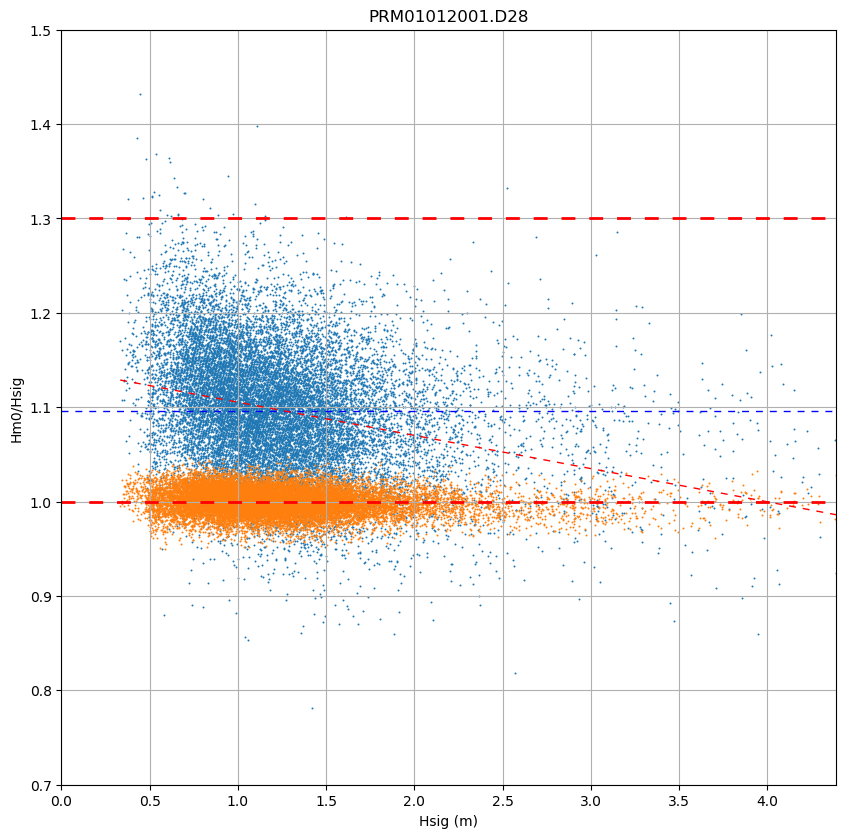

In [8]:
# Do scatter plot of Hm0/Hsig Ratio

# Generate descriptive statistics of Hm0/Hsig Ratio’s distribution
Ratio = recs.Hm0/recs.Hsig
median = Ratio.describe()[5]
plt.figure(figsize=(10,10),dpi=100)
recs = recs.loc[recs.Hsig>0]
plt.scatter(recs.Hsig,recs.Hm0/recs.Hsig,lw=0,marker='o',s=2)
plt.plot([0,max(recs.Hsig)],[median,median],lw=1.0,c="b",dashes=[5, 5, 5, 5])
plt.xlabel("Hsig (m)")
plt.ylabel("Hm0/Hsig")
plt.plot([0,max(recs.Hsig)],[1.3,1.3],lw=2.0,c="r",dashes=[5, 5, 5, 5])
plt.plot([0,max(recs.Hsig)],[1.0,1.0],lw=2.0,c="r",dashes=[5, 5, 5, 5])
plt.scatter(recs.Hsig,np.sqrt(2)*recs.Hm/recs.Hsig,lw=0,marker='o',s=2)

plt.grid(True)
plt.xlim(xmin=0,xmax=max(recs.Hsig))
plt.ylim(ymin=0.7,ymax=1.5)

from numpy.polynomial import Polynomial

p = Polynomial.fit(recs.Hsig,recs.Hm0/recs.Hsig, 1)
plt.plot(*p.linspace(),lw=1.0,c="r",dashes=[5, 5, 5, 5])

plt.title(site)
plt.show()

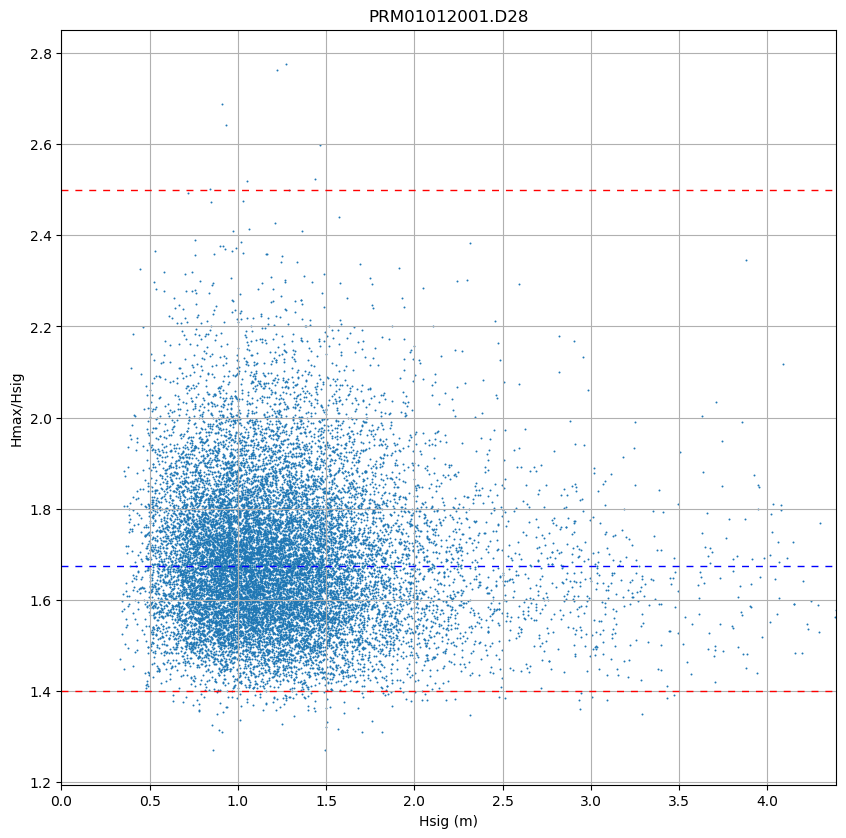

In [43]:
# Do scatter plot of Hmax/Hsig Ratio

# Generate descriptive statistics of Hm0/Hsig Ratio’s distribution
Ratio = recs.Hmax/recs.Hsig
median = Ratio.describe()[5]
plt.figure(figsize=(10,10),dpi=100)
recs = recs.loc[recs.Hsig>0]
plt.grid(True)
plt.scatter(recs.Hsig,recs.Hmax/recs.Hsig,lw=0,marker='o',s=2)
plt.plot([0,max(recs.Hsig)],[median,median],lw=1.0,c="b",dashes=[5, 5, 5, 5])
plt.xlabel("Hsig (m)")
plt.ylabel("Hmax/Hsig")
plt.plot([0,max(recs.Hsig)],[2.5,2.5],lw=1.0,c="r",dashes=[5, 5, 5, 5])
plt.plot([0,max(recs.Hsig)],[1.4,1.4],lw=1.0,c="r",dashes=[5, 5, 5, 5])

plt.xlim(xmin=0,xmax=max(recs.Hsig))

plt.title(site)
plt.show()

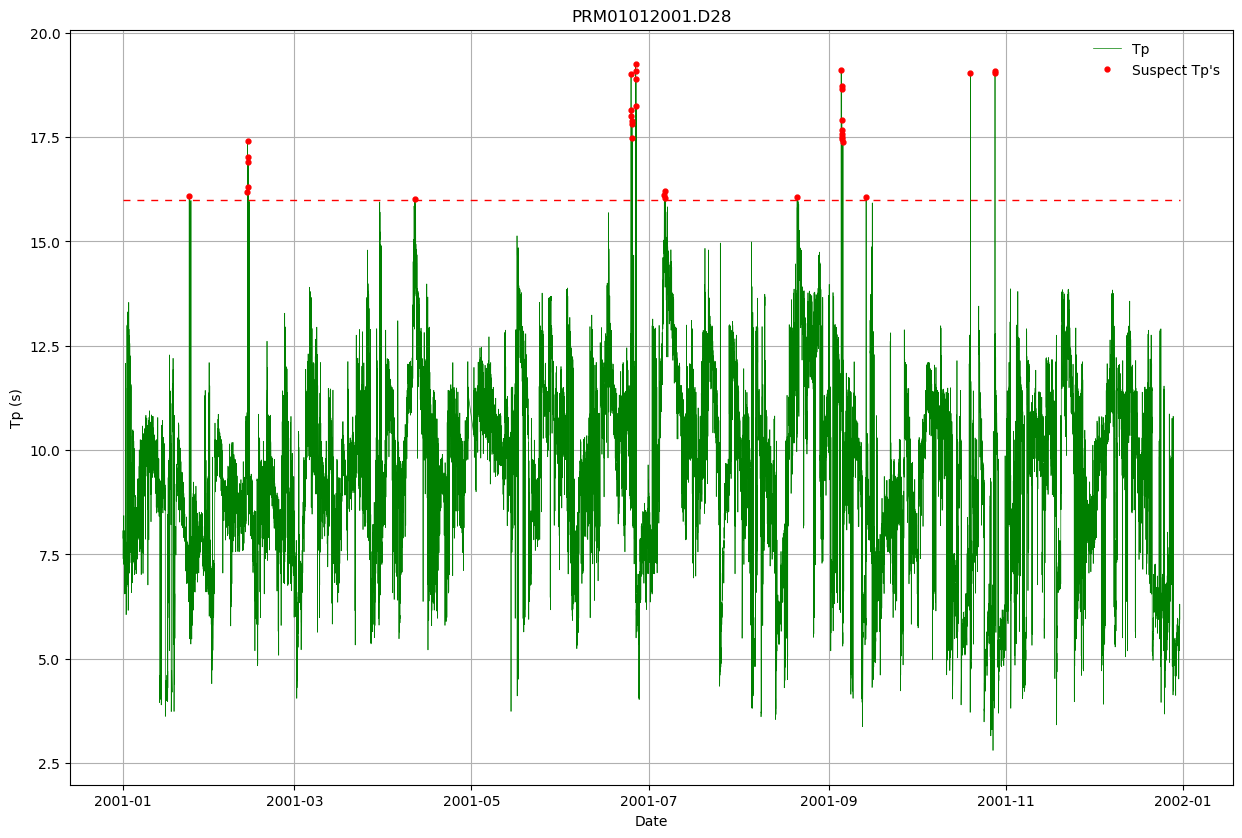

In [40]:
plt.figure(figsize=(15,10),dpi=100)
plt.title(site)

# only plot records where Hsig > 0
recs = recs.loc[recs.Hsig>0]

plt.grid(True)
plt.plot(recs.Tp,lw=0.5,c='g')
suspect_Tp = recs[~(recs.Tp).between(1,16,inclusive=False)]
plt.plot(suspect_Tp.Tp,lw=0,marker='o',ms=3.5,c='r')
plt.xlabel("Date")
plt.ylabel("Tp (s)")
plt.plot([recs.index[0],recs.index[-1]],[16.0,16.0],lw=1.0,c="r",dashes=[5, 5, 5, 5])

plt.ylabel("Tp (s)")

plt.legend(["Tp","Suspect Tp's"],frameon=False)
plt.show()


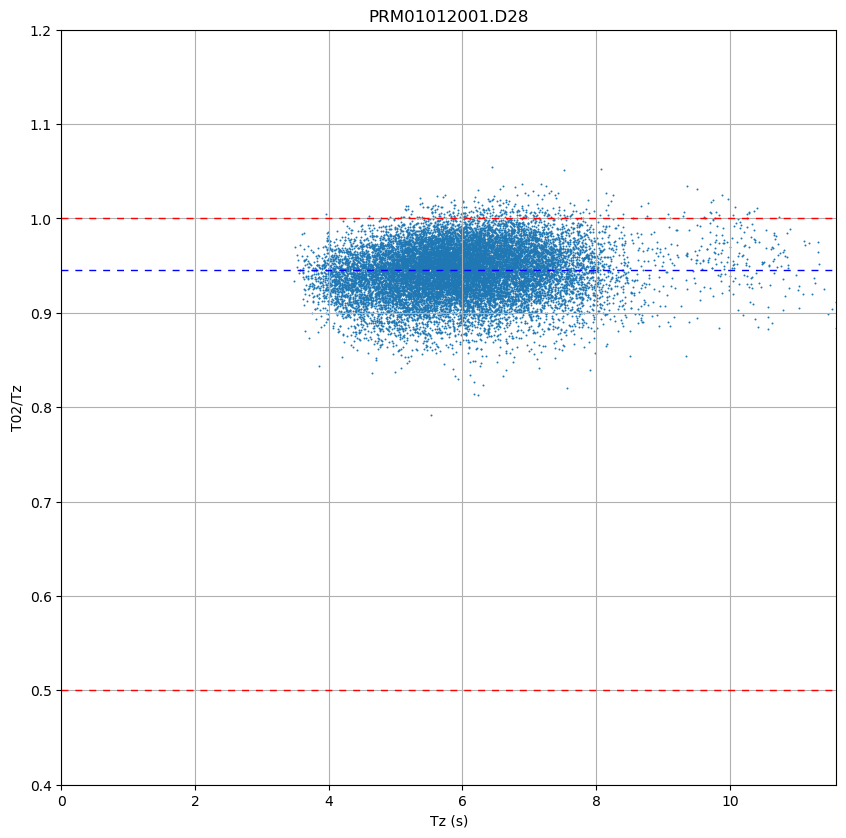

In [42]:
# Do scatter plot of T02/Tz Ratio

# Generate descriptive statistics of T02/Tz Ratio’s distribution
Ratio = recs.T02/recs.Tz
median = Ratio.describe()[5]
plt.figure(figsize=(10,10),dpi=100)
recs = recs.loc[recs.Hsig>0]
plt.grid(True)
plt.scatter(recs.Tz,recs.T02/recs.Tz,lw=0,marker='o',s=2)
plt.plot([0,max(recs.Tz)],[median,median],lw=1.0,c="b",dashes=[5, 5, 5, 5])
plt.xlabel("Tz (s)")
plt.ylabel("T02/Tz")
plt.plot([0,max(recs.Tz)],[1.0,1.0],lw=1.0,c="r",dashes=[5, 5, 5, 5])
plt.plot([0,max(recs.Tz)],[0.5,0.5],lw=1.0,c="r",dashes=[5, 5, 5, 5])

plt.xlim(xmin=0,xmax=max(recs.Tz))
plt.ylim(ymin=0.4,ymax=1.2)

plt.title(site)
plt.show()

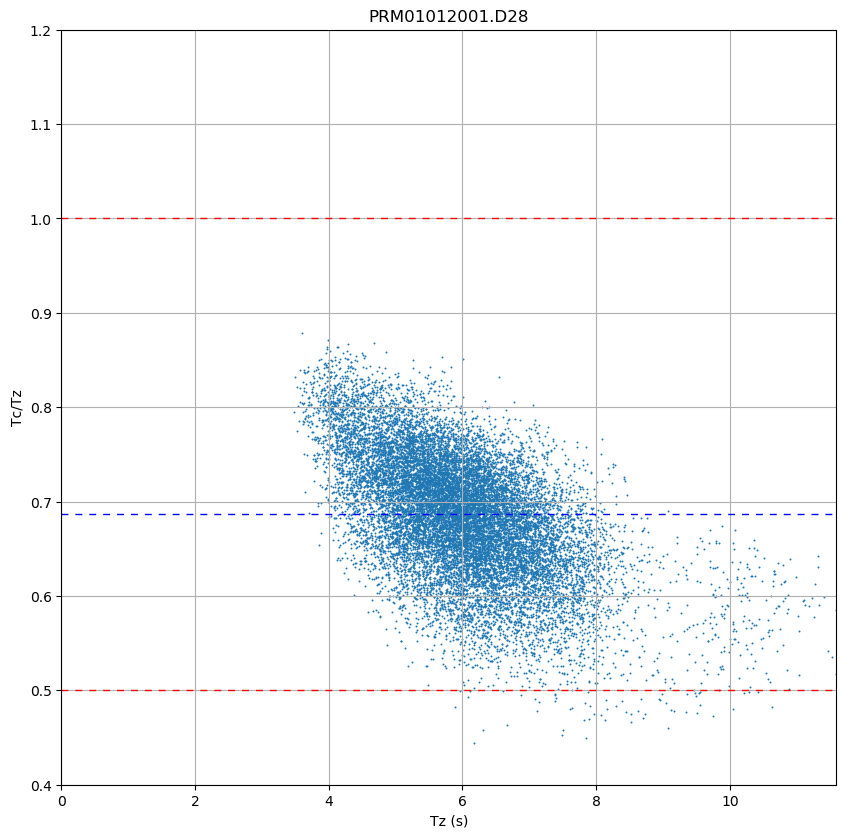

In [41]:
# Do scatter plot of Tc/Tz Ratio

# Generate descriptive statistics of Hm0/Hsig Ratio’s distribution
Ratio = recs.Tc/recs.Tz
median = Ratio.describe()[5]
plt.figure(figsize=(10,10),dpi=100)
recs = recs.loc[recs.Hsig>0]
plt.grid(True)
plt.scatter(recs.Tz,recs.Tc/recs.Tz,lw=0,marker='o',s=2)
plt.plot([0,max(recs.Tz)],[median,median],lw=1.0,c="b",dashes=[5, 5, 5, 5])
plt.xlabel("Tz (s)")
plt.ylabel("Tc/Tz")
plt.plot([0,max(recs.Tz)],[1.0,1.0],lw=1.0,c="r",dashes=[5, 5, 5, 5])
plt.plot([0,max(recs.Tz)],[0.5,0.5],lw=1.0,c="r",dashes=[5, 5, 5, 5])

plt.xlim(xmin=0,xmax=max(recs.Tz))
plt.ylim(ymin=0.4,ymax=1.2)

plt.title(site)
plt.show()

In [46]:
recs.Tp

2001-01-01 00:00:00    7.887893
2001-01-01 00:30:00    8.070948
2001-01-01 01:00:00    7.833322
2001-01-01 01:30:00    7.396053
2001-01-01 02:00:00    7.545778
2001-01-01 02:30:00    7.883428
2001-01-01 03:00:00    8.046188
2001-01-01 03:30:00    7.839069
2001-01-01 04:00:00    7.411641
2001-01-01 04:30:00    7.891459
2001-01-01 05:00:00    7.994585
2001-01-01 05:30:00    7.474528
2001-01-01 06:00:00    7.262842
2001-01-01 06:30:00    8.430395
2001-01-01 07:00:00    7.290608
2001-01-01 07:30:00    7.566659
2001-01-01 08:00:00    7.298062
2001-01-01 08:30:00    7.340890
2001-01-01 09:00:00    8.070246
2001-01-01 09:30:00    7.311991
2001-01-01 10:00:00    7.847677
2001-01-01 10:30:00    7.264333
2001-01-01 11:00:00    7.323620
2001-01-01 11:30:00    7.870361
2001-01-01 12:00:00    6.960896
2001-01-01 12:30:00    7.528915
2001-01-01 13:00:00    7.118681
2001-01-01 13:30:00    7.010567
2001-01-01 14:00:00    7.514588
2001-01-01 14:30:00    6.553337
                         ...   
2001-12-

In [7]:
recs

Date_val  Buoy  \
2001-01-01 00:00:00      [2001, 1, 1, 0, 0, 0]    28   
2001-01-01 00:30:00     [2001, 1, 1, 0, 30, 0]    28   
2001-01-01 01:00:00      [2001, 1, 1, 1, 0, 0]    28   
2001-01-01 01:30:00     [2001, 1, 1, 1, 30, 0]    28   
2001-01-01 02:00:00      [2001, 1, 1, 2, 0, 0]    28   
2001-01-01 02:30:00     [2001, 1, 1, 2, 30, 0]    28   
2001-01-01 03:00:00      [2001, 1, 1, 3, 0, 0]    28   
2001-01-01 03:30:00     [2001, 1, 1, 3, 30, 0]    28   
2001-01-01 04:00:00      [2001, 1, 1, 4, 0, 0]    28   
2001-01-01 04:30:00     [2001, 1, 1, 4, 30, 0]    28   
2001-01-01 05:00:00      [2001, 1, 1, 5, 0, 0]    28   
2001-01-01 05:30:00     [2001, 1, 1, 5, 30, 0]    28   
2001-01-01 06:00:00      [2001, 1, 1, 6, 0, 0]    28   
2001-01-01 06:30:00     [2001, 1, 1, 6, 30, 0]    28   
2001-01-01 07:00:00      [2001, 1, 1, 7, 0, 0]    28   
2001-01-01 07:30:00     [2001, 1, 1, 7, 30, 0]    28   
2001-01-01 08:00:00      [2001, 1, 1, 8, 0, 0]    28   
2001-01-01 08:30:00     [2001, 1, 1, 8, 30, 0]    28   
2001-01-01 09:00:00      [2001, 1, 1, 9, 0, 0]    28   
2001-01-01 09:30:00     [2001, 1, 1, 9, 30, 0]    28   
2001-01-01 10:00:00     [2001, 1, 1, 10, 0, 0]    28   
2001-01-01 10:30:00    [2001, 1, 1, 10, 30, 0]    28   
2001-01-01 11:00:00     [2001, 1, 1, 11, 0, 0]    28   
2001-01-01 11:30:00    [2001, 1, 1, 11, 30, 0]    28   
2001-01-01 12:00:00     [2001, 1, 1, 12, 0, 0]    28   
2001-01-01 12:30:00    [2001, 1, 1, 12, 30, 0]    28   
2001-01-01 13:00:00     [2001, 1, 1, 13, 0, 0]    28   
2001-01-01 13:30:00    [2001, 1, 1, 13, 30, 0]    28   
2001-01-01 14:00:00     [2001, 1, 1, 14, 0, 0]    28   
2001-01-01 14:30:00    [2001, 1, 1, 14, 30, 0]    28   
...                                        ...   ...   
2001-12-30 09:00:00    [2001, 12, 30, 9, 0, 0]    28   
2001-12-30 09:30:00   [2001, 12, 30, 9, 30, 0]    28   
2001-12-30 10:00:00   [2001, 12, 30, 10, 0, 0]    28   
2001-12-30 10:30:00  [2001, 12, 30, 10, 30, 0]    28   
2001-12-30 11:00:00   [2001, 12, 30, 11, 0, 0]    28   
2001-12-30 11:30:00  [2001, 12, 30, 11, 30, 0]    28   
2001-12-30 12:00:00   [2001, 12, 30, 12, 0, 0]    28   
2001-12-30 12:30:00  [2001, 12, 30, 12, 30, 0]    28   
2001-12-30 13:00:00   [2001, 12, 30, 13, 0, 0]    28   
2001-12-30 13:30:00  [2001, 12, 30, 13, 30, 0]    28   
2001-12-30 14:00:00   [2001, 12, 30, 14, 0, 0]    28   
2001-12-30 14:30:00  [2001, 12, 30, 14, 30, 0]    28   
2001-12-30 15:00:00   [2001, 12, 30, 15, 0, 0]    28   
2001-12-30 15:30:00  [2001, 12, 30, 15, 30, 0]    28   
2001-12-30 16:00:00   [2001, 12, 30, 16, 0, 0]    28   
2001-12-30 16:30:00  [2001, 12, 30, 16, 30, 0]    28   
2001-12-30 17:00:00   [2001, 12, 30, 17, 0, 0]    28   
2001-12-30 17:30:00  [2001, 12, 30, 17, 30, 0]    28   
2001-12-30 18:00:00   [2001, 12, 30, 18, 0, 0]    28   
2001-12-30 18:30:00  [2001, 12, 30, 18, 30, 0]    28   
2001-12-30 19:00:00   [2001, 12, 30, 19, 0, 0]    28   
2001-12-30 19:30:00  [2001, 12, 30, 19, 30, 0]    28   
2001-12-30 20:00:00   [2001, 12, 30, 20, 0, 0]    28   
2001-12-30 20:30:00  [2001, 12, 30, 20, 30, 0]    28   
2001-12-30 21:00:00   [2001, 12, 30, 21, 0, 0]    28   
2001-12-30 21:30:00  [2001, 12, 30, 21, 30, 0]    28   
2001-12-30 22:00:00   [2001, 12, 30, 22, 0, 0]    28   
2001-12-30 22:30:00  [2001, 12, 30, 22, 30, 0]    28   
2001-12-30 23:00:00   [2001, 12, 30, 23, 0, 0]    28   
2001-12-30 23:30:00  [2001, 12, 30, 23, 30, 0]    28   

                                            Verstr      Hsig        Hm  \
2001-01-01 00:00:00  [52, 46, 48, 50, 32, 0, 0, 0]  1.855312  1.320270   
2001-01-01 00:30:00  [52, 46, 48, 50, 32, 0, 0, 0]  1.834379  1.272420   
2001-01-01 01:00:00  [52, 46, 48, 50, 32, 0, 0, 0]  1.906618  1.352351   
2001-01-01 01:30:00  [52, 46, 48, 50, 32, 0, 0, 0]  1.750098  1.221615   
2001-01-01 02:00:00  [52, 46, 48, 50, 32, 0, 0, 0]  1.608562  1.131232   
2001-01-01 02:30:00  [52, 46, 48, 50, 32, 0, 0, 0]  1.544853  1.102650   
2001-01-01 03:00:00  [52, 46, 48, 50, 32, 0, 0,

In [8]:
datetime.strptime(date_str[3:], "%d%m%Y")

datetime.datetime

In [11]:
Start_File

'C:/QGHL/Wave_data/Master_files/twee----28.prim'